## POS tagging using modified Viterbi

### Data Preparation

In [232]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [233]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Kush\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [234]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))


In [235]:
# Print first 3 sentences along with tags
print(nltk_data[:3])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [236]:
# Splitting into train and testing set
random.seed(100)
train_set, test_set = train_test_split(nltk_data,train_size=0.95,test_size=0.05, random_state=42)

print(len(train_set))
print(len(test_set))
print(train_set[:20])

3718
196
[[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.20', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.272', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('2009', 'NUM'), ('.', '.')], [('``', '.'), ('They', 'PRON'), ('wer

In [237]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Total Tagged words {}".format(len(train_tagged_words)))
# tokens 
tokens = [pair for pair in train_tagged_words]
tokens[:10]

Total Tagged words 95589


[('Bank', 'NOUN'),
 ('of', 'ADP'),
 ('New', 'NOUN'),
 ('England', 'NOUN'),
 ("'s", 'PRT'),
 ('shares', 'NOUN'),
 ('are', 'VERB'),
 ('traded', 'VERB'),
 ('*-1', 'X'),
 ('on', 'ADP')]

In [238]:
# vocabulary
tokens = [pair[0] for pair in train_tagged_words]
V = set(tokens)
print("Words in Vocabulary {}".format(len(V)))
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print("Number of Tags {}".format(len(T)))
print(T)

Words in Vocabulary 12109
Number of Tags 12
{'DET', 'ADV', 'ADJ', 'VERB', 'X', 'PRT', 'CONJ', 'ADP', 'PRON', '.', 'NUM', 'NOUN'}


### Build the vanilla Viterbi based POS tagger

### 1.  POS Tagging Algorithm - HMM

#### 1.1 Emission Probabilities

In [239]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [240]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'ADV'))
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(27, 6077)
(0, 12885)
(0, 27423) 


 will
(0, 3010)
(1, 27423)
(268, 12885)

 book
(7, 27423)
(1, 12885)


### Inference:
- Large is tagged 6 times as adjectives
- Will is tagged 267 times as verb and 1 time as noun. 
- Book is tagged 6 times as noun and 1 time as a verb.

#### 1.2 Transition Probabilities


In [241]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)


# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1(',', 'CONJ'))
print(t2_given_t1('CONJ', 'NOUN'))
print(t2_given_t1('VERB', 'NOUN'))
print(t2_given_t1('PRON', 'VERB'))

(4234, 6077)
(5302, 8284)
(1429, 12885)
(0, 2131)
(1150, 27423)
(4058, 27423)
(467, 12885)


In [242]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,DET,ADV,ADJ,VERB,X,PRT,CONJ,ADP,PRON,.,NUM,NOUN
DET,0.005311,0.012313,0.204973,0.038387,0.045509,0.000241,0.000483,0.009054,0.003742,0.017986,0.021970,0.640029
ADV,0.067110,0.081063,0.130233,0.344518,0.023588,0.013621,0.006312,0.119601,0.015615,0.136877,0.030565,0.030897
ADJ,0.005101,0.004608,0.066645,0.012342,0.021392,0.010861,0.016949,0.078986,0.000658,0.065328,0.020405,0.696725
VERB,0.133101,0.082577,0.064649,0.169189,0.218005,0.031121,0.005588,0.090493,0.036244,0.035312,0.022817,0.110904
X,0.055131,0.025175,0.016571,0.203633,0.076482,0.185787,0.010357,0.142925,0.056087,0.163799,0.002709,0.061345
PRT,0.100360,0.010134,0.086303,0.402746,0.013403,0.001635,0.002288,0.021576,0.018960,0.041517,0.058516,0.242563
CONJ,0.121539,0.055842,0.116847,0.153918,0.007977,0.004693,0.000469,0.054435,0.058658,0.034256,0.042234,0.349132
ADP,0.326378,0.013162,0.105297,0.008240,0.034029,0.001498,0.000856,0.017228,0.069128,0.039486,0.062921,0.321776
PRON,0.009549,0.033995,0.074866,0.480901,0.092819,0.012223,0.004966,0.022918,0.008021,0.041253,0.007257,0.211230
.,0.173502,0.052078,0.044972,0.088505,0.026623,0.002339,0.057924,0.091114,0.065389,0.093812,0.080500,0.223152


In [243]:
tags_df.loc['.', :]

DET     0.173502
ADV     0.052078
ADJ     0.044972
VERB    0.088505
X       0.026623
PRT     0.002339
CONJ    0.057924
ADP     0.091114
PRON    0.065389
.       0.093812
NUM     0.080500
NOUN    0.223152
Name: ., dtype: float32

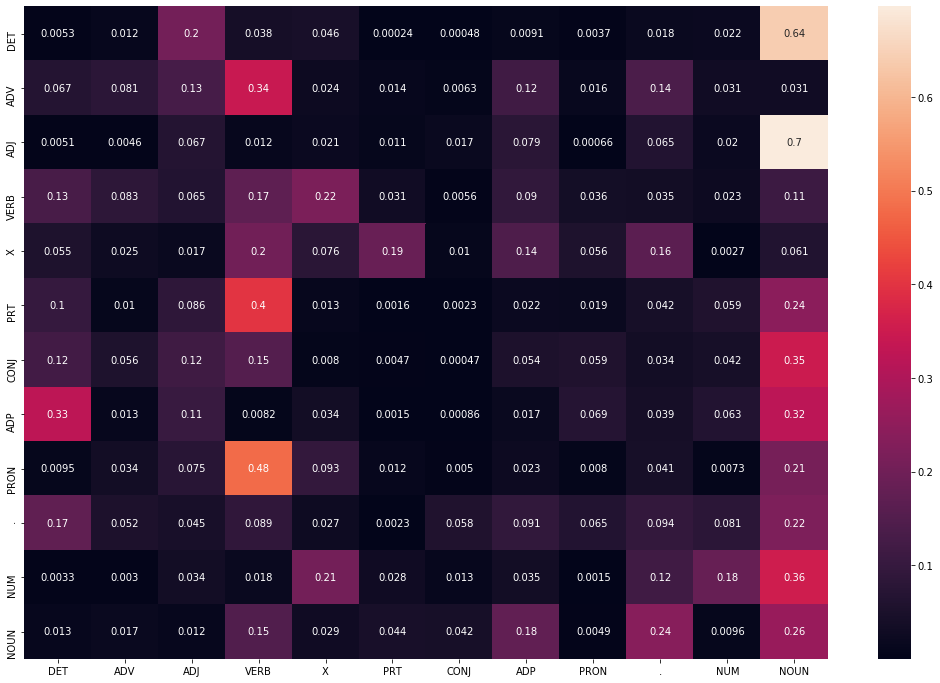

In [244]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, annot=True)
plt.show()

### Inferences:

We can clearly see as most of the times 'det' and 'adj' are followed by 'noun', they have the highest corelation.


#### 1.3 Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [245]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### 1.4 Evaluating on test set

In [246]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_tagged_words[:10]

['Shearson', '``', 'really', 'only', 'has', '$', '300', 'million', '*U*', 'of']

In [247]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [248]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  75.7879958152771
[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'DET'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'DET'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'DET'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets', '

In [249]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(check)/len(tagged_seq)
print("Accuracy = {}".format(vanilla_viterbi_accuracy))

Accuracy = 0.9095238095238095


In [250]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('ShareData', 'NOUN'), (('develops', 'DET'), ('develops', 'VERB'))],
 [('and', 'CONJ'), (('markets', 'NOUN'), ('markets', 'VERB'))],
 [('markets', 'VERB'), (('low-cost', 'DET'), ('low-cost', 'ADJ'))],
 [('settled', 'VERB'), (('pre-1917', 'DET'), ('pre-1917', 'ADJ'))],
 [('When', 'ADV'), (('test', 'VERB'), ('test', 'NOUN'))],
 [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADV'))],
 [('she', 'PRON'), (('copied', 'DET'), ('copied', 'VERB'))],
 [('totaled', 'VERB'), (('154.2', 'DET'), ('154.2', 'NUM'))],
 [('been', 'VERB'), (('enormously', 'DET'), ('enormously', 'ADV'))],
 [('enormously', 'ADV'), (('frustrating', 'DET'), ('frustrating', 'VERB'))],
 [('computer', 'NOUN'), (('science', 'DET'), ('science', 'NOUN'))],
 [('was', 'VERB'), (('raring', 'DET'), ('raring', 'ADJ'))],
 [('to', 'PRT'), (('invent', 'DET'), ('invent', 'VERB'))],
 [('another', 'DET'), (('Walkman', 'DET'), ('Walkman', 'NOUN'))],
 [('was', 'VERB'), (('soliciting', 'DET'), ('soliciting', 'VERB'))],
 [('sell', 'VERB'), (('TXO', 

### Solve the problem of unknown words

### Modification 1: Unknown words replaced by noun as noun being the most common tag for unknown words

#### Tags of all unknown words are Tagged as noun
Till now if the word was unkown emision prob was becoming 0.
Then all the POS are equally likely and randomly first tag is taken.
Therefore, hard code equal to noun regarding the unkown word. 
Different random state value 

In [251]:
# Modified Version 1 of Viterbi Heuristic 
def ModifiedViterbi1(test_words, train_bag = train_tagged_words):
    tagged = Viterbi(test_words)
    words = [pair[0] for pair in tagged]
    tags  = [pair[1] for pair in tagged]
    for key, word in enumerate(words):
        if word not in V:
            tags[key] = 'NOUN'
    return list(zip(words,tags))

### Testing the data

In [252]:
# tagging the test sentences
start = time.time()
tagged_seq_mod1 = ModifiedViterbi1(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq_mod1)

Time taken in seconds:  75.32595419883728
[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'NOUN'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'NOUN'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'NOUN'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets

#### Evaluating tagging accuracy

In [260]:
# accuracy
check = [i for i, j in zip(tagged_seq_mod1, test_run_base) if i == j] 
accuracy_viterbi_modified1 = len(check)/len(tagged_seq_mod1)
print("Accuracy = {}".format(accuracy_viterbi_modified1))
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_mod1, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

Accuracy = 0.9238095238095239


[[('ShareData', 'NOUN'), (('develops', 'NOUN'), ('develops', 'VERB'))],
 [('and', 'CONJ'), (('markets', 'NOUN'), ('markets', 'VERB'))],
 [('markets', 'VERB'), (('low-cost', 'NOUN'), ('low-cost', 'ADJ'))],
 [('settled', 'VERB'), (('pre-1917', 'NOUN'), ('pre-1917', 'ADJ'))],
 [('When', 'ADV'), (('test', 'VERB'), ('test', 'NOUN'))],
 [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADV'))],
 [('she', 'PRON'), (('copied', 'NOUN'), ('copied', 'VERB'))],
 [('totaled', 'VERB'), (('154.2', 'NOUN'), ('154.2', 'NUM'))],
 [('been', 'VERB'), (('enormously', 'NOUN'), ('enormously', 'ADV'))],
 [('enormously', 'ADV'), (('frustrating', 'NOUN'), ('frustrating', 'VERB'))],
 [('was', 'VERB'), (('raring', 'NOUN'), ('raring', 'ADJ'))],
 [('to', 'PRT'), (('invent', 'NOUN'), ('invent', 'VERB'))],
 [('was', 'VERB'), (('soliciting', 'NOUN'), ('soliciting', 'VERB'))],
 [('TXO', 'NOUN'), (("'s", 'VERB'), ("'s", 'PRT'))],
 [('of', 'ADP'), (('manmade-fiber', 'NOUN'), ('manmade-fiber', 'ADJ'))],
 [('$', '.'), (('405', 'NOU

### By Comparing the incorrect tagged cases of Vanila Viterbi and 1st modification of Viterbi algorithm we see: 
- Word 'Walkman' was incorrectly identified by Vanilla Viterbi as 'DET' and Modication 1 correctly identified it as 'NOUN'
- Word 'Science' was incorrectly identified by Vanilla Viterbi as 'DET' and Modication 1 correctly identified it as 'NOUN'

### Modification 2: Rule based algorithm for unknown words and making it work in tqandem with viterbi

In [261]:
def find_pattern(text, patterns):
    if re.search(patterns, text):
        return True
    else:
        return False

In [262]:
if find_pattern("arriving", '^[aA-zZ]+(ed|ing|es)$') == True:
    print("VERB")

VERB


In [263]:
# Modified Version 2 of Viterbi Heuristic 
def ModifiedViterbi2(test_words, train_bag = train_tagged_words):
    tagged = Viterbi(test_words)
    words = [pair[0] for pair in tagged]
    tags  = [pair[1] for pair in tagged]
    for key, word in enumerate(words):
        if word not in V:
            if (find_pattern(word, '.*ous$') == True or find_pattern(word, '.*able$') == True or find_pattern(word, '.*ful$') == True):
                tags[key] = "ADJ"
            elif find_pattern(word, '[0-9].?[,\/]?[0-9]*') == True:
                tags[key] = "NUM" 
            elif find_pattern(word, '(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$') == True:
                tags[key] = "DET" 
            elif find_pattern(word, '^[aA-zZ]+(ed|ing)$') == True:
                tags[key] = "VERB"
            elif find_pattern(word, '.*ly$') == True:
                tags[key] = "ADV"  
            elif word.upper()==word or word[0].upper()==word[0]:
                tags[key] = "NOUN"
            else:
                tags[key] = "NOUN"
                
    return list(zip(words,tags))

In [264]:
# tagging the test sentences
start = time.time()
tagged_seq_mod2 = ModifiedViterbi2(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq_mod2)

Time taken in seconds:  85.4307861328125
[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'NOUN'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'NOUN'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'NUM'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets',

In [267]:
# accuracy
check = [i for i, j in zip(tagged_seq_mod2, test_run_base) if i == j] 
accuracy_viterbi_modified2 = len(check)/len(tagged_seq_mod2)
print("Accuracy = {}".format(accuracy_viterbi_modified2))
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_mod2, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

Accuracy = 0.9476190476190476


[[('ShareData', 'NOUN'), (('develops', 'NOUN'), ('develops', 'VERB'))],
 [('and', 'CONJ'), (('markets', 'NOUN'), ('markets', 'VERB'))],
 [('markets', 'VERB'), (('low-cost', 'NOUN'), ('low-cost', 'ADJ'))],
 [('settled', 'VERB'), (('pre-1917', 'NUM'), ('pre-1917', 'ADJ'))],
 [('When', 'ADV'), (('test', 'VERB'), ('test', 'NOUN'))],
 [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADV'))],
 [('was', 'VERB'), (('raring', 'VERB'), ('raring', 'ADJ'))],
 [('to', 'PRT'), (('invent', 'NOUN'), ('invent', 'VERB'))],
 [('another', 'DET'), (('Walkman', 'DET'), ('Walkman', 'NOUN'))],
 [('TXO', 'NOUN'), (("'s", 'VERB'), ("'s", 'PRT'))],
 [('of', 'ADP'), (('manmade-fiber', 'NOUN'), ('manmade-fiber', 'ADJ'))]]

### By Comparing the incorrect tagged cases of Vanila Viterbi and Rule based modified Viterbi algorithm we see
- 'soliciting' and frustrating' was incorrectly identified as 'DET' but Rule based modification correctly identified them as 'VERB
- 'TXO' was incorrectly identified as as 'DET' but Rule based modification correctly identified them as 'NOUN'

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [268]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy], 
                  ['Viterbi Modified1 - NOUN for unknowns', accuracy_viterbi_modified1], 
                  ['Viterbi Modified2 - Rule Based', accuracy_viterbi_modified2]
                 ]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Algorithm', 'Accuracy'])

acccuracy_data_df.set_index('Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Accuracy
Algorithm,
Vanilla Viterbi,0.909524
Viterbi Modified1 - NOUN for unknowns,0.923810
Viterbi Modified2 - Rule Based,0.947619


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [269]:
## Testing
sentence_test = "Android is a mobile operating system developed by Google. \
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. \
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. \
Twitter is an online news and social networking service on which users post and interact with messages known as tweets. \
Before entering politics, Donald Trump was a domineering businessman and a television personality. \
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. \
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. \
Show me the cheapest round trips from Dallas to Atlanta I would like to see flights from Denver to Philadelphia. \
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. \
NASA invited social media users to experience the launch of ICESAT-2 Satellite."

words = word_tokenize(sentence_test)

In [270]:
# tagging the test sentences with vanila Viterbi
start = time.time()
tagged_seq_sentence = Viterbi(words)
end = time.time()
difference = end-start
print("Time taken for vanila Viterbi= {}".format(difference))
print(tagged_seq_sentence)

Time taken for vanila Viterbi= 78.91139316558838
[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'

In [271]:
# tagging the test sentences ModifiedViterbi1
start = time.time()
tagged_seq_sentence_mod1 = ModifiedViterbi1(words)
end = time.time()
difference = end-start
print(tagged_seq_sentence_mod1)
print("Time taken for ModifiedViterbi1= {}".format(difference))


[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'VERB'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'

In [272]:
# tagging the test sentences with ModifiedViterbi2
start = time.time()
tagged_seq_sentence_mod2 = ModifiedViterbi2(words)
end = time.time()
difference = end-start
print(tagged_seq_sentence_mod2)
print("Time taken for ModifiedViterbi2= {}".format(difference))


[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'VERB'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), 

In [273]:
for i in range(len(tagged_seq_sentence)):
    tup = tagged_seq_sentence[i]
    tup1 = tagged_seq_sentence_mod1[i]
    tup2 = tagged_seq_sentence_mod2[i]
    if(tup[1]!=tup1[1]):
        print("Mod1 : {} , {}".format(tup,tup1))
    if(tup[1]!=tup1[1]):
        print("Mod2: {} , {}".format(tup,tup2))

Mod1 : ('Android', 'DET') , ('Android', 'NOUN')
Mod2: ('Android', 'DET') , ('Android', 'NOUN')
Mod1 : ('Google', 'DET') , ('Google', 'NOUN')
Mod2: ('Google', 'DET') , ('Google', 'NOUN')
Mod1 : ('Android', 'DET') , ('Android', 'NOUN')
Mod2: ('Android', 'DET') , ('Android', 'NOUN')
Mod1 : ('OS', 'DET') , ('OS', 'NOUN')
Mod2: ('OS', 'DET') , ('OS', 'NOUN')
Mod1 : ('worldwide', 'DET') , ('worldwide', 'NOUN')
Mod2: ('worldwide', 'DET') , ('worldwide', 'NOUN')
Mod1 : ('smartphones', 'DET') , ('smartphones', 'NOUN')
Mod2: ('smartphones', 'DET') , ('smartphones', 'NOUN')
Mod1 : ('2011', 'DET') , ('2011', 'NOUN')
Mod2: ('2011', 'DET') , ('2011', 'NUM')
Mod1 : ('2013', 'DET') , ('2013', 'NOUN')
Mod2: ('2013', 'DET') , ('2013', 'NUM')
Mod1 : ('Google', 'DET') , ('Google', 'NOUN')
Mod2: ('Google', 'DET') , ('Google', 'NOUN')
Mod1 : ('Twitter', 'DET') , ('Twitter', 'NOUN')
Mod2: ('Twitter', 'DET') , ('Twitter', 'NOUN')
Mod1 : ('2015', 'DET') , ('2015', 'NOUN')
Mod2: ('2015', 'DET') , ('2015', 'NUM'

#### We can see that the above words were incorrectly tagged by vanilla Viterbi. By comparing the results of all the three algorithms, following are few sample test cases.

- Android, google. Twitter and OS were tagged as 'DET' by vanilla Viterbi whereas modified Viterbi tagged it as 'NOUN'
- 'invited' and 'domineering' were incorrectly tagged as 'DET' by vanilla Viterbi. Modification 1 tagged them as 'NOUN' whereas Rule based Modification correctly tagged them as 'VERB'
- Years like 2018. 2013, 2015 were incorrectly tagged as 'DET' by vanilla Viterbi. Modification 1 tagged them as 'NOUN' whereas Rule based Modification correctly tagged it as 'NUM'